# A1: Recommender Systems (part II)#
Group 72: Marija Trajanoska (marijatrajanoska@gmail.com), and 
         Joshiwa van Marrewijk (joshiwa01@gmail.com)

This is part II of a two-part project. In the previous part we applied four naive models as a baseline for comparison with a more advanced system in order predict user-ratings about movies. 

In this part we build the more advanced system. The system is based on _On the Gravity Recommendation System_ article by Gabor Takacs et al.. The approach for this system is called Matrix factorization. The details of approach are explained below. To test this system we calculated the Root Mean Square Error (RMSE) and applied a 5-fold cross-validation to test the stabillity of the model. 

The definition and formula for the RMSE as well as the 5-fold cross-validation are shown in part I.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import scipy
from multiprocessing import Pool
from IPython.display import clear_output

sb.set_style('whitegrid')
sb.set_context('notebook')

### Load and explore the data ###
Here we load in the data from the 1M movielens data set. This data consists of 6040 users and 3952 movie's. There are in total 1000209 movie ratings. The data is read from file and put in a DataFrame with the pandas package. 

In [2]:
#load data
df = pd.read_csv('ratings.dat', delimiter = '::', header = None, engine = 'python')
df.columns = ['UserId', 'MovieId', 'Rating', 'Time']
df

,UserId,MovieId,Rating,Time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


### Declaring Constants ###

Below are the constants necessary for running the model.

In [3]:
# insert constants
item_size = 3952 #amount of movies
user_size = 6040 #amount of users
amount = 1000 # maximum number of iterations for the gradient descent
nfolds = 5 # number of folds for the cross-validations
split = int(user_size/nfolds) # split size for obtaining each fold in the cross-validation
R_global = df['Rating'].mean() # global mean rating

# setting the seed to something, to make sure the results can be replicated
np.random.seed(17)

## Matrix factorization: Theory ##

The approach implemented in this notebook is mainly based on the article cited above by Gabor Takacs et al. The theory behind matrix factorization is as follows. We want to approximate the prediction matrix $X$ as the product of two matrices, $U$ and $I$, such that: $X = UI$, with $U$ being a $MxK$ matrix and $I$ a $KxN$. The matrix $X$ has dimensions $MxN$, which refer to (N-users X N-items). 

Matrix $U$ will have one row per user and $K$-columns. Matrix $I$ will have one column per item and K-rows. The value for $K$ will usually be in the range 20-300, but will in any case be much smaller than the number of users or items. That is why we can imagine matrices $U$ and $I$-transposed as thin and long matrices. The idea is that we are mapping each user and item into some space which has $K$-dimensions. For movies, these dimensions can represent real characteristics of the data, such as "geared towards males vs females" or "serious vs funny". The columns in $I$ can intuitively be thought of as the properties of the item, and the rows in $U$ as the user's preferences towards those properties.

Given that we obtain matrices $U$ and $I$, we can estimate the missing ratings by finding the corresponding row and column in $U$ and $I$ and obtaining their dot product, or weighted combination. We can measure the accuracy of the model by calculating the RMSE between the prediction matrix and the matrix filled with the real ratings. The lowest RMSE produces the best model. Thus by optimizing matrices $U$ and $I$ we can improve the RMSE of the model. We optmize these matrixes with the gradient descent method. 

The gradient descent method takes the derivative of: $E^2 = (\text{Ratings} - X)^2$ where $Ratings$ is the matrix containing the real ratings, and adds the weights in the opposite direction of the gradient:

$U = U + \eta \ (2 E * I)$ and $I = I + \eta \ (2 E * U)$, with $\eta$ the learning rate. 

This methods tends to prefer large values for the single features in the $U$ and $I$ matrix. As the ratings are between 1 and 5 we must prevent large features, thus we introduce a $\lambda$ factor to prevents large weights (features):

$U = U + \eta \ (2 E * I - \lambda U)$ and $I = I + \eta \ (2 E * U -  \lambda I)$, with $\lambda, \eta$ small positive numbers. 

In theory, we iterate over the $Ratings$ matrix until convergence. The implementation of approach in code as well as the handing of the edge cases is explained below.

## Matrix factorization: Implimentation ##

We first create a numpy matrix (ndim array) from the given data. The matrix is a sparse matrix with dimensions (N-users X N-items). When a particular item (movie) has not been rating by a particular user, the value in the matrix is set to NaN. Every element in the matrix is given it's own index between 0 and 4 randomly. The indexes are used to select which ratings we use for the train or test data set. 

In [4]:
# let's create the rating matrix from the real data and shuffle it

R_real = np.zeros((item_size, user_size)).T # allocate space for the matrix
R_real[:,:] = np.nan # fill the matrix with NaNs
R_real[df['UserId']-1,df['MovieId']-1] = df['Rating'].values # have indices start from 0

#set indexes on the elements of the matrix with a random permutation to apply cross-validation
R_index = np.random.choice([0,1,2,3,4], size=R_real.shape)

### Searching for the best values for $\eta$ and $\lambda$ ##

The two cells below are used to iterate over $\eta$ and $\lambda$. We tested over 54 X 120  different combinations. We selected the RMSE on a single train data set of one of the five folds, to reduce computation time. Every combination runs 50 iterations over the gradient descent and then determines the final RMSE. If the RMSE of that specific paramter combination is lower than the previous lowest RMSE, then we save the values for $\eta$ and $\lambda$ until a lower RMSE is found. The best fitted parameters are listed below.

In [5]:
def get_constants(lda, Irate):
    """
    A function that returns the RMS of the train data set after 50 illiterations with given illiteration constant
    """
    vector_size = 20
     # split data in train to obtain train set
    train_mask = np.ones_like(R_index, dtype=float)
    train_mask[R_index[:,:] == 0] = np.nan
    train = R_real.copy() * train_mask
    
    #let's make a matrix for the factorization. 
    scaling = np.sqrt(R_global/vector_size)
    
    u_matrix_train = np.random.rand(user_size, vector_size)*0.1 - 0.05 +  scaling 
    v_matrix_train = np.random.rand(item_size, vector_size).T*0.1 - 0.05 +scaling 
    
    #do the gradient descent with matrix multiplications, like in gravity tikk article
    for i in range(50):
        error_train_true = train - np.dot(u_matrix_train, v_matrix_train)
        error_train = np.copy(error_train_true)
        error_train[np.isnan(error_train_true)] = 0

        #gradiant descent
        u_matrix_train = u_matrix_train + Irate * (2*np.dot(error_train, v_matrix_train.T) - lda*u_matrix_train)
        v_matrix_train = v_matrix_train + Irate * (2*np.dot(error_train.T, u_matrix_train).T - lda*v_matrix_train)
        RMS = np.sqrt(np.nanmean(error_train_true**2))
    
    return RMS

In [6]:
def test_it(run = False):
    """
    test which illiteration constants are best suited for the gradiant descent
    """
    #please don't run this again, it took a long time, just use the ones we found. 
    if run:
        lbda_test = np.arange(0.024, 0.06, 0.001)
        Irate_test = np.arange(0.00001, 0.006, 0.00005)        
        print(len(lbda_test), len(Irate_test))
        RMS = 5
        values = [0.001,0.0001]
        for i in lbda_test:
            for j in Irate_test:
                RMS_new = get_constants(i,j)
                if RMS_new < (RMS-0.001):
                    RMS = RMS_new
                    values = [i,j]
                    np.savetxt('saved/values.txt',np.array(values))

                    clear_output(True)
                    print('=====================')
                    print('{} {:04.4f}'.format("RMS:", RMS))
                    print('Obtained parameters')
                    print('{} {}'.format("lambda", " eta "))
                    print('{:06.6f} {:06.6f}'.format(i,j))
                    print('=====================')
                        
    else:
        values = [0.05, 0.0001]
        print('====================')
        print('Obtained parameters')
        print('{} {}'.format("lambda", " eta "))
        print('{:06.2f}  {:06.4f}'.format(values[0],values[1]))
        print('====================')
    return values

In [7]:
values = test_it(run=False)

Obtained parameters
lambda  eta 
000.05  0.0001


### Hyperparametriztion optimilization continued

We computed the grid search above, but by accident the computation was stopped early and due to lack of time we did not finish the grid search. Herefore we selected $\lambda$ and $\eta$ by hand. For the iteration constant ($\eta$) we choose the largest value for $\eta$, to minimize computation time, without the RMSE reachng for infinity. See the discussion section for further explanition on the behaviour of the RMSE for larger iteration constants. 

We did save every $\lambda$ and $\eta$, which found a lower RMSE with the grid search than the previous combination to a text file. Although the grid search did not finish it did show a pattarn to prefer high values for $\lambda$. This makes sense as the data visualizations show that the model overfits when the iteration time increases, herefore we correct with a larger $\lambda$, to correct for larger weights that cause the model to overfit. The final values for $\lambda$ and $\eta$ are listed above. 

We further choose to set the amount of features to 10. The gravity Tikk article has a larger amount of features. But when the feature amount increases, the complexity of the model increases aswell and so does its computation time. Due to the scope of the assignment and the lack of computational power, we decided to keep the feature size at a relatively small number, as complexer model tent to overftt very quickly without testing the proper configurations of constants. 

### Five-fold cross-validation ###

Below we looped over the 5 folds of the cross-validation. We split the data into five folds, with the indexes we randomly pertubated over the elements in the ratings matrix. Consequently, the train data is 4 times the size of the test data. 

### Initializing the user and item matrices ###
Afterwards we construct the User and Item matrices. In our case, we made these matrices such that K=10, i.e. they contain 10 features per row. It is important to initialize these matrices in an adequate way in order to speed up convergence. Using the methodology described by Takacs et al., the matrices cannot be initialized to constant values, because then each row and each column will remain a constant value, and separate factors (dimensions) will not exist. For this reason, the matrices have to be initialized randomly from some distribution. To initialize the matrices, we sampled values from a uniform distribution [-0.05,0.05], and added the square root of the global mean divided by the amount of features ($\text{scaling} = \sqrt{\frac{R_{global}}{\text{features}}}$). This way, the dot product of the matrices gives is the prediction matrix with a mean of the global matrix. This heavily reduces computation time, because at the very start of training, the RMSE is already the same as that of the first basic model of part I. We deviated the range of the uniform distribution, from [-0.05,0.05] upto [-0.5,0.5]. But the smaller deviations gave the smallest seperations between the test and train set after larger iterations. 

### Performing gradient descent ###
After the $U$ and $I$ (u and v in the code) are initialized, we compute their dot product and subtract it from the matrix with the real ratings. As the dot product between the two factors can exceed the maximum rating of 5, we clipped the final predicted rating between 1 and 5. We also tried the sigmoid function ($\text{Sig} = \frac{1}{1+e^{-x}}$) to rescale the ratings between 1 and 5, but that seemed to be less effective. 

Futher, the places where the real matrix contains NaN values are also transferred to the error matrix, so it contains the same amount of ratings. The RMSE over this error can easily be calculated with the _numpy.nanmean()_ function which neglects all NaNs in the array. After the RMSE calculation we set all NaNs at zero to be able to do the gradient descent. The zeros do not affect the gradient because the dot product with 0 in any element returns zero and thus does not affect the outcome. The iterations stop when the RMSE of the last interation is larger than the RMSE of the previous two interations. When this happens, we conclude that the model has converged and cannot get better. The same convergence condition is used in the article by Takacs et al. For the sake of computation time, we set an upper-bound to the number of iterations at 1000.

### Handling unknown users/items in the test set ###
With 6040 users and above 1,000,000 ratings the probability of 1 user being in the test set but not in the train set (or vice versa) is very small; too small to assume it would make a noticable difference on testing the model. But in the case it occured we simply put a NaN in the user prediction of the real data and neglect that specific user when calculating the RMSE. 

In [8]:
#do the 5 fold cross validation
lda = values[0]
Irate = values[1]
vector_size = 10 #features in the factorization
scaling = np.sqrt(R_global/vector_size)

# allocating space to save data
rms_train = np.empty(0)
rms_test = np.empty(0)
iteration = np.zeros(nfolds)

for idx in range(nfolds):
    #select the values for cross-validation
    train_mask = np.ones_like(R_index, dtype=float)
    train_mask[R_index[:,:] == idx] = np.nan
    test_mask = np.ones_like(R_index, dtype=float)
    test_mask[(R_index[:,:] != idx)] = np.nan
        
    train = R_real.copy() * train_mask
    test  = R_real.copy() * test_mask
    
    # let's make a matrix for the factorization 
    u_matrix_train = np.random.rand(user_size, vector_size)*0.1 - 0.05 +  scaling 
    v_matrix_train = np.random.rand(item_size, vector_size).T*0.1  - 0.05 +scaling 

    # allocating space to save data
    errors_train = np.empty(0)
    errors_test = np.empty(0)
    
    # do the gradient descent with matrix multiplications, like in gravity tikk article
    previous3 = 7
    previous2 = 6
    previous1 = 5   
    RMS_train = 1
    i = 0
    statement = True
    while (RMS_train<(previous2) and RMS_train<(previous3)) and (i < amount):
        error_train_true = train - np.clip(np.dot(u_matrix_train, v_matrix_train),1,5)
        error_train = np.copy(error_train_true)
        error_train[np.isnan(error_train_true)] = 0

        #gradiant descent
        u_matrix_train = u_matrix_train + Irate * (2*np.dot(error_train, v_matrix_train.T) - lda*u_matrix_train)
        v_matrix_train = v_matrix_train + Irate * (2*np.dot(error_train.T, u_matrix_train).T - lda*v_matrix_train)
        errors_train = np.append(errors_train, np.sqrt(np.nanmean(error_train_true**2)))
        
        error_test_true = test - np.dot(u_matrix_train, v_matrix_train)
        errors_test = np.append(errors_test, np.sqrt(np.nanmean(error_test_true**2))) 
        
        #visualize the results with a live plot (implementing the live plot-slowes down 5 times) 
        clear_output(True)
#         plt.figure()
#         plt.title('live plot of the RMSE descent fold_'+str(idx))
#         plt.plot(np.arange(0,i+1), errors_train, label='train')
#         plt.plot(np.arange(0,i+1), errors_test, label='test')
#         plt.legend()
#         plt.ylabel('RMS')
#         plt.xlabel('iterations of gradient descent')
#         plt.show()
    
        #stop if error value is larger than previous two values (like in Tikk) and update parameters
        RMS_train = np.sqrt(np.nanmean(error_train_true**2))
        previous3 = previous2
        previous2 = previous1
        previous1 = RMS_train
        i += 1

    iteration[idx] = i
    rms_train = np.append(rms_train, errors_train)
    rms_test = np.append(rms_test, errors_test)

4 999


# Results visualization #

We visualized the data per fold by plotting the RMSE of the gradient descent per illiteration. For the sake of of visualization we run a fifteen iterations per fold to see how low the RMSE eventually end up to be. Below these 5 plots (we have 5 folds) we showed the RMSE of the last value before convergence per plot to test the stabillity of the model. We also showed a comperisson after 200 illiterations. 

Finally, the average RMS over each fold, plus their std are shown below. 

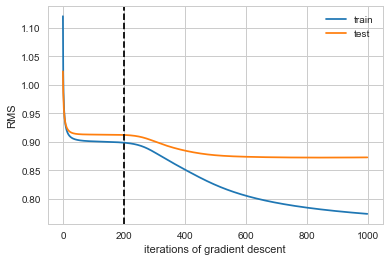

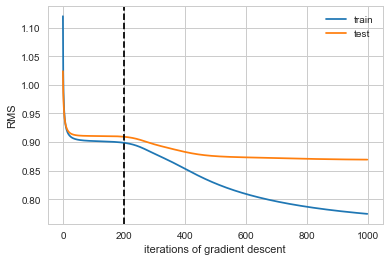

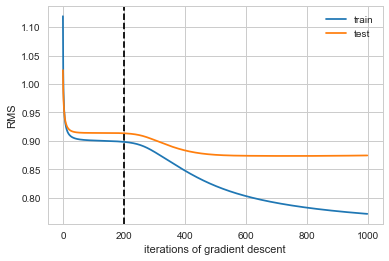

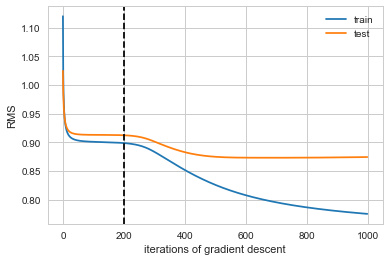

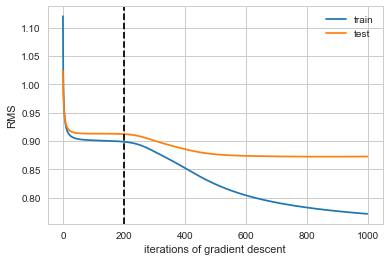

In [9]:
#let's visualize eats folds iteration process
cum = np.cumsum(iteration)

for idx, sliced in enumerate(iteration):
    if idx == 0:
        plt.figure()
        plt.plot(np.arange(0, iteration[idx]), rms_train[int(idx*sliced):int((idx+1)*sliced)], label='train')
        plt.plot(np.arange(0, iteration[idx]), rms_test[int(idx*sliced):int((idx+1)*sliced)], label='test')
        plt.axvline(200,linestyle='--', color = 'black')
        plt.legend()
        plt.ylabel('RMS')
        plt.xlabel('iterations of gradient descent')
        plt.show()
    else:
        plt.figure()
        plt.plot(np.arange(0, iteration[idx]), rms_train[int(cum[idx-1]):int(cum[idx])], label='train')
        plt.plot(np.arange(0, iteration[idx]), rms_test[int(cum[idx-1]):int(cum[idx])], label='test')
        plt.axvline(200,linestyle='--', color = 'black')
        plt.legend()
        plt.ylabel('RMS')
        plt.xlabel('iterations of gradient descent')
        plt.show()

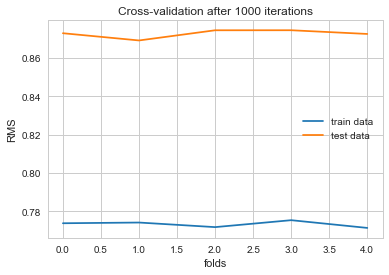

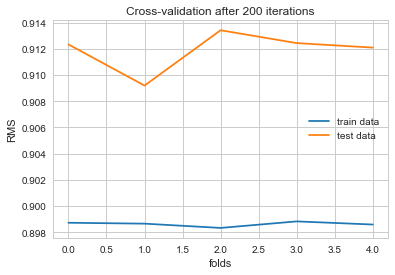

Mean error on the total train data:  0.773 with a std on the error of: 0.002
Mean error on the total test data:  0.873 with a std on the error of: 0.002

Mean error after 200 it. of the train data:  0.899 with a std on the error of: 0.000
Mean error after 200 it. of the test data:  0.912 with a std on the error of: 0.001


In [13]:
RMS_final_train = np.empty(0)
RMS_final_test = np.empty(0)
RMS_200_train = np.empty(0)
RMS_200_test = np.empty(0)

for idx, i in enumerate(cum):
    i = int(i-1)
    RMS_final_train = np.append(RMS_final_train, rms_train[i])
    RMS_final_test  = np.append(RMS_final_test, rms_test[i])
    RMS_200_train   = np.append(RMS_200_train, rms_train[200+idx*amount])
    RMS_200_test    = np.append(RMS_200_test, rms_test[200+idx*amount])
    

plt.figure()
plt.title('Cross-validation after 1000 iterations')
plt.plot(np.arange(0,nfolds), RMS_final_train, label = 'train data')
plt.plot(np.arange(0,nfolds), RMS_final_test, label = 'test data')
plt.legend()
plt.xlabel('folds')
plt.ylabel('RMS')
plt.show()

plt.figure()
plt.title('Cross-validation after 200 iterations')
plt.plot(np.arange(0,nfolds), RMS_200_train, label = 'train data')
plt.plot(np.arange(0,nfolds), RMS_200_test, label = 'test data')
plt.legend()
plt.xlabel('folds')
plt.ylabel('RMS')
plt.show()

print("=============================================================================")
print('{} {:04.3f} {} {:04.3f}'.format("Mean error on the total train data: ", np.mean(RMS_final_train), 'with a std on the error of:', np.std(RMS_final_train)))
print('{} {:04.3f} {} {:04.3f}'.format("Mean error on the total test data: ", np.mean(RMS_final_test), 'with a std on the error of:', np.std(RMS_final_test)))
print("=============================================================================")
print()
print("====================================================================================")
print('{} {:04.3f} {} {:04.3f}'.format("Mean error after 200 it. of the train data: ", np.mean(RMS_200_train), 'with a std on the error of:', np.std(RMS_200_train)))
print('{} {:04.3f} {} {:04.3f}'.format("Mean error after 200 it. of the test data: ", np.mean(RMS_200_test), 'with a std on the error of:', np.std(RMS_200_test)))
print("====================================================================================")

# Discussion and Conclusion

The first phenomena we observed was that when we implemented the initial parameters for $\lambda$ and $\eta$, which were given in the slides, were unsuccesful. The RMSE only increased and after one iteration it reached a value of 1e40. When we lowered the learing rate we observed more intuitive result. The RMSE decreased exponentually-like shown in the plots above.

Further, at the start of the simulation, there is an offset between the train and test data set of roughly 10%. We assume that is due to change. The train and test data sets are randomly picked which might cause the test set more resembles to the global mean (which we used as mean value to initialize the $U$ and $I$ matrix) than the train set.

After roughly 50 iterations the model seems to overfit the train set, slightly. Eventhough the test set also decreases by iteration, at iteration ~ 200-300 the train set decreases faster than the test set and thus the model really starts to overfit the data. Therefore we sliced the RMSE at an iteration of 200 to maximize the RMSE, and minimize the deviation between the test and train set. Therefore the RMSE we obtained from the 200th iterations is considered the most reliable measurement of our model. We included the 1000th iteration to show the lowest RMSE we could obtain for the train data set with our limit computation time. We further observed that the gradient descent did not converge after 1000th iterations. This means that, the model can still be more improved, but when we look at the plots, we conclude that the model overfits. Thus futhure work might want to consider different methods of convergence detection or implement another stop condition.  

Due to a lack of computional time, and as a more advanced hyper parameterization of the iteration constant is beyond the scope of this project, we got an RMSE of 0.899. This value can still be improved with a more precise selection of feature size, maybe a scalable Iteration constant, or a different variation on the $\lambda$-variable. Although the final RMSE can still be optimized we score more than twice the improvement on a randomised racommization model (shown below), and improved the basic models of part 1. 

We we run 1000 iterations on the train set we even improved the RMSE of the article written by Gabor Takacs et al.  "_On the Gravity Recommendation System_", which scored a RMSE of 0.8808, by 14%. But our RMSE after 1000 iterations overfits the train data and cannot be considered as trustable measurement. 

In [11]:
print("The RMSE on a randomly distributed recommandation system", np.sqrt(np.nanmean((R_real - (np.random.rand(user_size,item_size)*4+1))**2)))

The RMSE on a randomly distributed recommandation system 1.7097360828064356
